In [11]:
import pyodbc
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
import numpy as np


pd.options.mode.chained_assignment = None

In [12]:
### QUERY ###
query = """
SET NOCOUNT ON;
    DECLARE @startdate DATETIME
	DECLARE @enddate DATETIME
    DECLARE @date DATETIME 
    DECLARE @count INT 
	DECLARE @jobno CHAR(20)

	DECLARE @afd TABLE (Value INT)
	INSERT INTO @afd VALUES (421)
	INSERT INTO @afd VALUES (505)
	INSERT INTO @afd VALUES (515)


    SET @startdate = '2017-01-01' 
	SET @enddate = '2022-12-22' 

	SET @jobno = ''

    ;WITH Sager AS (
    SELECT *
    From [NRGIDW_Extract].[elcon].[Job] AS Sager
    WHERE 1=1
	AND Sager.No_ = @jobno OR Coalesce(@jobno,'') = ''
	AND Sager.[Status] = 2
    AND (Sager.[Job Posting Group] = 'FASTPRIS' OR Sager.[Job Posting Group] = 'PROJEKT')),

    Sagsopgaver AS(
    SELECT
	Sagsopgaver.[Global Dimension 1 Code]
    ,Sagsopgaver.[Job No_]
    ,Sagsopgaver.[Job Task No_]
    ,Sagsopgaver.[Description]
    FROM [NRGIDW_Extract].[elcon].[Job Task] AS Sagsopgaver
    INNER JOIN Sager
    On Sager.[No_] = Sagsopgaver.[Job No_]
    WHERE 1=1
	AND Sagsopgaver.[Global Dimension 1 Code] IN (SELECT Value FROM @afd)),

    Sagsbudget AS(
    SELECT 
    Sagsopgaver.[Job No_]
    ,SUM(CASE Sagsbudget.[Line Type] WHEN 1 THEN Sagsbudget.[Line Amount (LCY)] WHEN 2 THEN [Line Amount (LCY)] ELSE 0 END) AS 'Indtægtsbudget'
    ,SUM(CASE Sagsbudget.[Line Type] WHEN 0 THEN Sagsbudget.[Total Cost (LCY)] WHEN 2 THEN [Total Cost (LCY)] ELSE 0 END) AS 'Omkostningsbudget'
    FROM [NRGIDW_Extract].[elcon].[Job Planning Line Entry] AS Sagsbudget
    Inner JOIN Sagsopgaver
    ON CONCAT(Sagsbudget.[Job No_],Sagsbudget.[Job Task No_]) = CONCAT(Sagsopgaver.[Job No_],Sagsopgaver.[Job Task No_])
    INNER JOIN Sager
    ON Sager.[No_]=Sagsbudget.[Job No_]
    GROUP BY 
    Sagsopgaver.[Job No_]),

    Arbejdssedler AS(
    SELECT 
    Arbejdssedler.[Source No_]
    ,Count(Arbejdssedler.[Source No_]) AS Antal
    FROM [NRGIDW_Extract].[elcon].[Work Order Header] AS Arbejdssedler
    INNER JOIN Sager
    ON Sager.[No_] = Arbejdssedler.[Source No_]
    WHERE 1=1
	AND (NOT(Arbejdssedler.[Status] = 3) OR Arbejdssedler.[Status] IS NULL)
    GROUP BY Arbejdssedler.[Source No_]),

    Sagsposter AS(
    SELECT
	FORMAT(Sagsposter.[Posting Date],'dd-MM-yyyy') AS 'Dato'
    ,Datepart(iso_week,Sagsposter.[Posting Date]) AS 'Uge'
	,CONCAT(Datepart(iso_week,Sagsposter.[Posting Date]),'-',FORMAT(Sagsposter.[Posting Date], 'yyyy')) AS 'Uge-år'
	,FORMAT(Sagsposter.[Posting Date], 'MM-yyyy') AS 'Måned-år'
	,FORMAT(Sagsposter.[Posting Date], 'yyyy') AS 'År'
	,Sagsposter.[Global Dimension 1 Code] AS 'Afd'
    ,Sagsposter.[Job No_]
    ,-SUM(CASE Sagsposter.[Entry Type] WHEN 1 THEN Sagsposter.[Line Amount (LCY)] ELSE 0 END) AS 'Faktureret indtægt'
    ,SUM(CASE Sagsposter.[Entry Type] WHEN 0 THEN Sagsposter.[Total Cost (LCY)] ELSE 0 END) AS 'Bogført omkostning'
    ,SUM(CASE Sagsposter.[Entry Type] WHEN 0 THEN CASE Sagsposter.[Type] WHEN 0 THEN Sagsposter.[Total Cost (LCY)] ELSE 0 END ELSE 0 END) AS 'Ressource omkostning'
    ,SUM(CASE Sagsposter.[Entry Type] WHEN 0 THEN CASE Sagsposter.[Type] WHEN 1 THEN Sagsposter.[Total Cost (LCY)] ELSE 0 END ELSE 0 END) AS 'Vare omkostning'
    ,SUM(CASE Sagsposter.[Entry Type] WHEN 0 THEN CASE Sagsposter.[Type] WHEN 2 THEN Sagsposter.[Total Cost (LCY)] ELSE 0 END ELSE 0 END) AS  'Andre omkostning'
    ,MAX(Sagsposter.[Posting Date]) AS 'Seneste bogføringsdato'
    ,-SUM(CASE Sagsposter.[Entry Type] WHEN 1 THEN CASE Format(Sagsposter.[Posting Date],'yyyy-MM') WHEN FORMAT(@startdate,'yyyy-MM')THEN
    Sagsposter.[Line Amount (LCY)] ELSE 0 END ELSE 0 END) AS 'Faktureret i måneden'
    ,SUM(CASE Sagsposter.[Entry Type] WHEN 0 THEN CASE Format(Sagsposter.[Posting Date],'yyyy-MM') WHEN FORMAT(@startdate,'yyyy-MM')THEN
    Sagsposter.[Total Cost (LCY)] ELSE 0 END ELSE 0 END) AS 'Forbrug i måneden'
    FROM [NRGIDW_Extract].[elcon].[Job Ledger Entry] AS Sagsposter
    INNER JOIN Sagsopgaver
    ON CONCAT(Sagsposter.[Job No_],Sagsposter.[Job Task No_]) = CONCAT(Sagsopgaver.[Job No_],Sagsopgaver.[Job Task No_])
    INNER JOIN Sager
    ON Sager.[No_]=Sagsposter.[Job No_]
    WHERE 1=1
	AND Sagsposter.[Posting Date] BETWEEN @startdate AND @enddate
    GROUP BY 
	Sagsposter.[Global Dimension 1 Code],
    Sagsposter.[Job No_],
	Sagsposter.[Posting Date]
	)
    
    SELECT DISTINCT
    Sagsposter.[Dato]
	,Sagsposter.[Uge]
	,Sagsposter.[Måned-år]
	,Sagsposter.[År]
    ,Sager.[Job Posting Group] AS 'Sagsbogføringsgruppe'
	,Sagsposter.[Afd]
    ,Sager.[No_] AS 'Sagsnr.'
    ,Sager.[Description] AS 'Beskrivelse'
    ,Kunder.[Name] AS 'Kundenavn'
    --,CONCAT(Sager.[Ship-to Address],' ',Sager.[Ship-to Post Code],' ',Sager.[Ship-to City]) AS Leveringsadresse
    --,Medarbejdere.[Name] AS Ansvarlig
    ,ISNULL(Sagsbudget.[Indtægtsbudget],0) AS 'Slut vurdering indtægt'
    ,ISNULL(Sagsbudget.[Omkostningsbudget],0) AS 'Slut vurdering omkostning'
    ,ISNULL(Sagsbudget.[Indtægtsbudget],0) - ISNULL(Sagsbudget.[Omkostningsbudget],0) AS 'Slut vurdering DB'
    ,ISNULL(Sagsposter.[Faktureret indtægt],0) AS 'Faktureret indtægt'
    ,ISNULL(Sagsposter.[Bogført omkostning],0) 'Bogført omkostning'
    ,ISNULL(Sagsposter.[Ressource omkostning],0) AS 'Ressource omkostning'
    ,ISNULL(Sagsposter.[Vare omkostning],0) AS 'Vare omkostning'
    ,ISNULL(Sagsposter.[Andre omkostning],0) AS  'Andre omkostning'
    --,ISNULL(Arbejdssedler.[Antal],0) AS 'Antal ikke lukkede arbejdssedler på sagen'
    FROM Sagsopgaver
    LEFT JOIN [NRGIDW_Extract].[elcon].[DynamicsNavHyperlink] AS Link
    ON Link.[Sagsnummer]=Sagsopgaver.[Job No_]
    Left JOIN Sagsposter
    ON  Sagsopgaver.[Job No_] = Sagsposter.[Job No_]
    INNER JOIN Sager
    ON Sager.[No_]=Sagsopgaver.[Job No_]
    LEFT JOIN [NRGIDW_Extract].[elcon].[Customer] AS Kunder
    ON Kunder.[No_]=Sager.[Bill-to Customer No_]
    LEFT JOIN [NRGIDW_Extract].[elcon].[Resource] AS Medarbejdere
    ON Medarbejdere.[No_]=Sager.[Person Responsible]
    LEFT JOIN Sagsbudget
    ON Sagsopgaver.[Job No_] = Sagsbudget.[Job No_]
    Left JOIN Arbejdssedler
    ON Arbejdssedler.[Source No_] = Sagsopgaver.[Job No_]
    WHERE 1=1
	AND (CASE WHEN ISNULL(Sagsbudget.[Indtægtsbudget],0) = 0 THEN 0 ELSE 1 END +
		 CASE WHEN ISNULL(Sagsbudget.[Omkostningsbudget],0) = 0 THEN 0 ELSE 1 END +
		 CASE WHEN ISNULL(Sagsposter.[Bogført omkostning],0) = 0 THEN 0 ELSE 1 END +
		 CASE WHEN ISNULL(Sagsposter.[Faktureret indtægt],0) = 0 THEN 0 ELSE 1 END) <> 0
	ORDER BY [Afd],[Sagsnr.],[Dato]
 """

In [3]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=SARDUSQLBI01;'
                      'Database=NRGIDW_Extract;'
                      'Trusted_Connection=yes;')

df = pd.read_sql_query(query, conn)

c:\Users\tobr\AppData\Local\miniconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
df['Dato'] = pd.to_datetime(df['Dato'], dayfirst=True)
df['Måned-år'] = pd.to_datetime(df['Måned-år'], format = '%m-%Y')
df.index = df['Dato']
df = df.drop(columns=['Dato'])
df['DG'] = df['Slut vurdering DB']/df['Slut vurdering indtægt']

In [5]:
# Fetch top 10 sagsnumre based on slut vurdering indtægt
param = 'Slut vurdering indtægt'
top10 = df.groupby(['Sagsnr.'])[param].sum().nlargest(10).index.tolist()

In [6]:
top10

['S268074',
 'S307965',
 'S283202',
 'S296594',
 'S310525',
 'S287209',
 'S283201',
 'S296442',
 'S325023',
 'S328073']

In [7]:
# Function to transform values
def fTransform(df,dN):
    df = df.sort_index()
    # Calculate the profit of the project
    df['DB'] = df['Faktureret indtægt'] - df['Bogført omkostning']

    # Get values in millions
    df['Slut vurdering indtægt'] = df['Slut vurdering indtægt']/1000000
    df['Slut vurdering omkostning'] = df['Slut vurdering omkostning']/1000000
    df['Slut vurdering DB'] = df['Slut vurdering DB']/1000000
    df['Faktureret indtægt'] = df['Faktureret indtægt']/1000000
    df['Bogført omkostning'] = df['Bogført omkostning']/1000000
    df['Ressource omkostning'] = df['Ressource omkostning']/1000000
    df['Vare omkostning'] = df['Vare omkostning']/1000000
    df['Andre omkostning'] = df['Andre omkostning']/1000000
    df['DB'] = df['DB']/1000000

    # Calculate the cumulative sum of the project
    df['Slut vurdering indtægt'] = df['Slut vurdering indtægt'].cumsum()
    df['Slut vurdering omkostning'] = df['Slut vurdering omkostning'].cumsum()
    df['Slut vurdering DB'] = df['Slut vurdering DB'].cumsum()
    df['Faktureret indtægt'] = df['Faktureret indtægt'].cumsum()
    df['Bogført omkostning'] = df['Bogført omkostning'].cumsum()
    df['Ressource omkostning'] = df['Ressource omkostning'].cumsum()
    df['Vare omkostning'] = df['Vare omkostning'].cumsum()
    df['Andre omkostning'] = df['Andre omkostning'].cumsum()
    df['DB'] = df['DB'].cumsum()

    # Calculate the dN moving average
    df['Slut vurdering indtægt'] = df['Slut vurdering indtægt'].rolling(dN).mean()
    df['Slut vurdering omkostning'] = df['Slut vurdering omkostning'].rolling(dN).mean()
    df['Slut vurdering DB'] = df['Slut vurdering DB'].rolling(dN).mean()
    df['Faktureret indtægt'] = df['Faktureret indtægt'].rolling(dN).mean()
    df['Bogført omkostning'] = df['Bogført omkostning'].rolling(dN).mean()
    df['Ressource omkostning'] = df['Ressource omkostning'].rolling(dN).mean()
    df['Vare omkostning'] = df['Vare omkostning'].rolling(dN).mean()
    df['Andre omkostning'] = df['Andre omkostning'].rolling(dN).mean()
    df['DB'] = df['DB'].rolling(dN).mean()

    # Calculate the rolling DG
    df['DG'] = (df['Faktureret indtægt']-df['Bogført omkostning'])/df['Faktureret indtægt']

    # Calculate the budget DG
    df['Slut vurdering DG'] = df['Slut vurdering DB']/df['Slut vurdering indtægt']

    return df

In [8]:
# Create df for each item in top10 and get values from df
dN = 60

dfJob1 = fTransform(df[df['Sagsnr.'].str.contains(top10[0])],dN).dropna()
dfJob2 = fTransform(df[df['Sagsnr.'].str.contains(top10[1])],dN).dropna()
dfJob3 = fTransform(df[df['Sagsnr.'].str.contains(top10[2])],dN).dropna()
dfJob4 = fTransform(df[df['Sagsnr.'].str.contains(top10[3])],dN).dropna()
dfJob5 = fTransform(df[df['Sagsnr.'].str.contains(top10[4])],dN).dropna()
dfJob6 = fTransform(df[df['Sagsnr.'].str.contains(top10[5])],dN).dropna()
dfJob7 = fTransform(df[df['Sagsnr.'].str.contains(top10[6])],dN).dropna()
dfJob8 = fTransform(df[df['Sagsnr.'].str.contains(top10[7])],dN).dropna()
dfJob9 = fTransform(df[df['Sagsnr.'].str.contains(top10[8])],dN).dropna()
dfJob10 = fTransform(df[df['Sagsnr.'].str.contains(top10[9])],dN).dropna()


In [9]:
# Get description of the project
dfJob1Desc = dfJob1.iloc[0]['Afd'] +' - '+ dfJob1.iloc[0]['Sagsnr.'] +' - '+ dfJob1.iloc[0]['Beskrivelse']
dfJob2Desc = dfJob2.iloc[0]['Afd'] +' - '+ dfJob2.iloc[0]['Sagsnr.'] +' - '+ dfJob2.iloc[0]['Beskrivelse']
dfJob3Desc = dfJob3.iloc[0]['Afd'] +' - '+ dfJob3.iloc[0]['Sagsnr.'] +' - '+ dfJob3.iloc[0]['Beskrivelse']
dfJob4Desc = dfJob4.iloc[0]['Afd'] +' - '+ dfJob4.iloc[0]['Sagsnr.'] +' - '+ dfJob4.iloc[0]['Beskrivelse']
dfJob5Desc = dfJob5.iloc[0]['Afd'] +' - '+ dfJob5.iloc[0]['Sagsnr.'] +' - '+ dfJob5.iloc[0]['Beskrivelse']
dfJob6Desc = dfJob6.iloc[0]['Afd'] +' - '+ dfJob6.iloc[0]['Sagsnr.'] +' - '+ dfJob6.iloc[0]['Beskrivelse']
dfJob7Desc = dfJob7.iloc[0]['Afd'] +' - '+ dfJob7.iloc[0]['Sagsnr.'] +' - '+ dfJob7.iloc[0]['Beskrivelse']
dfJob8Desc = dfJob8.iloc[0]['Afd'] +' - '+ dfJob8.iloc[0]['Sagsnr.'] +' - '+ dfJob8.iloc[0]['Beskrivelse']
dfJob9Desc = dfJob9.iloc[0]['Afd'] +' - '+ dfJob9.iloc[0]['Sagsnr.'] +' - '+ dfJob9.iloc[0]['Beskrivelse']
dfJob10Desc = dfJob10.iloc[0]['Afd'] +' - '+ dfJob10.iloc[0]['Sagsnr.'] +' - '+ dfJob10.iloc[0]['Beskrivelse']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


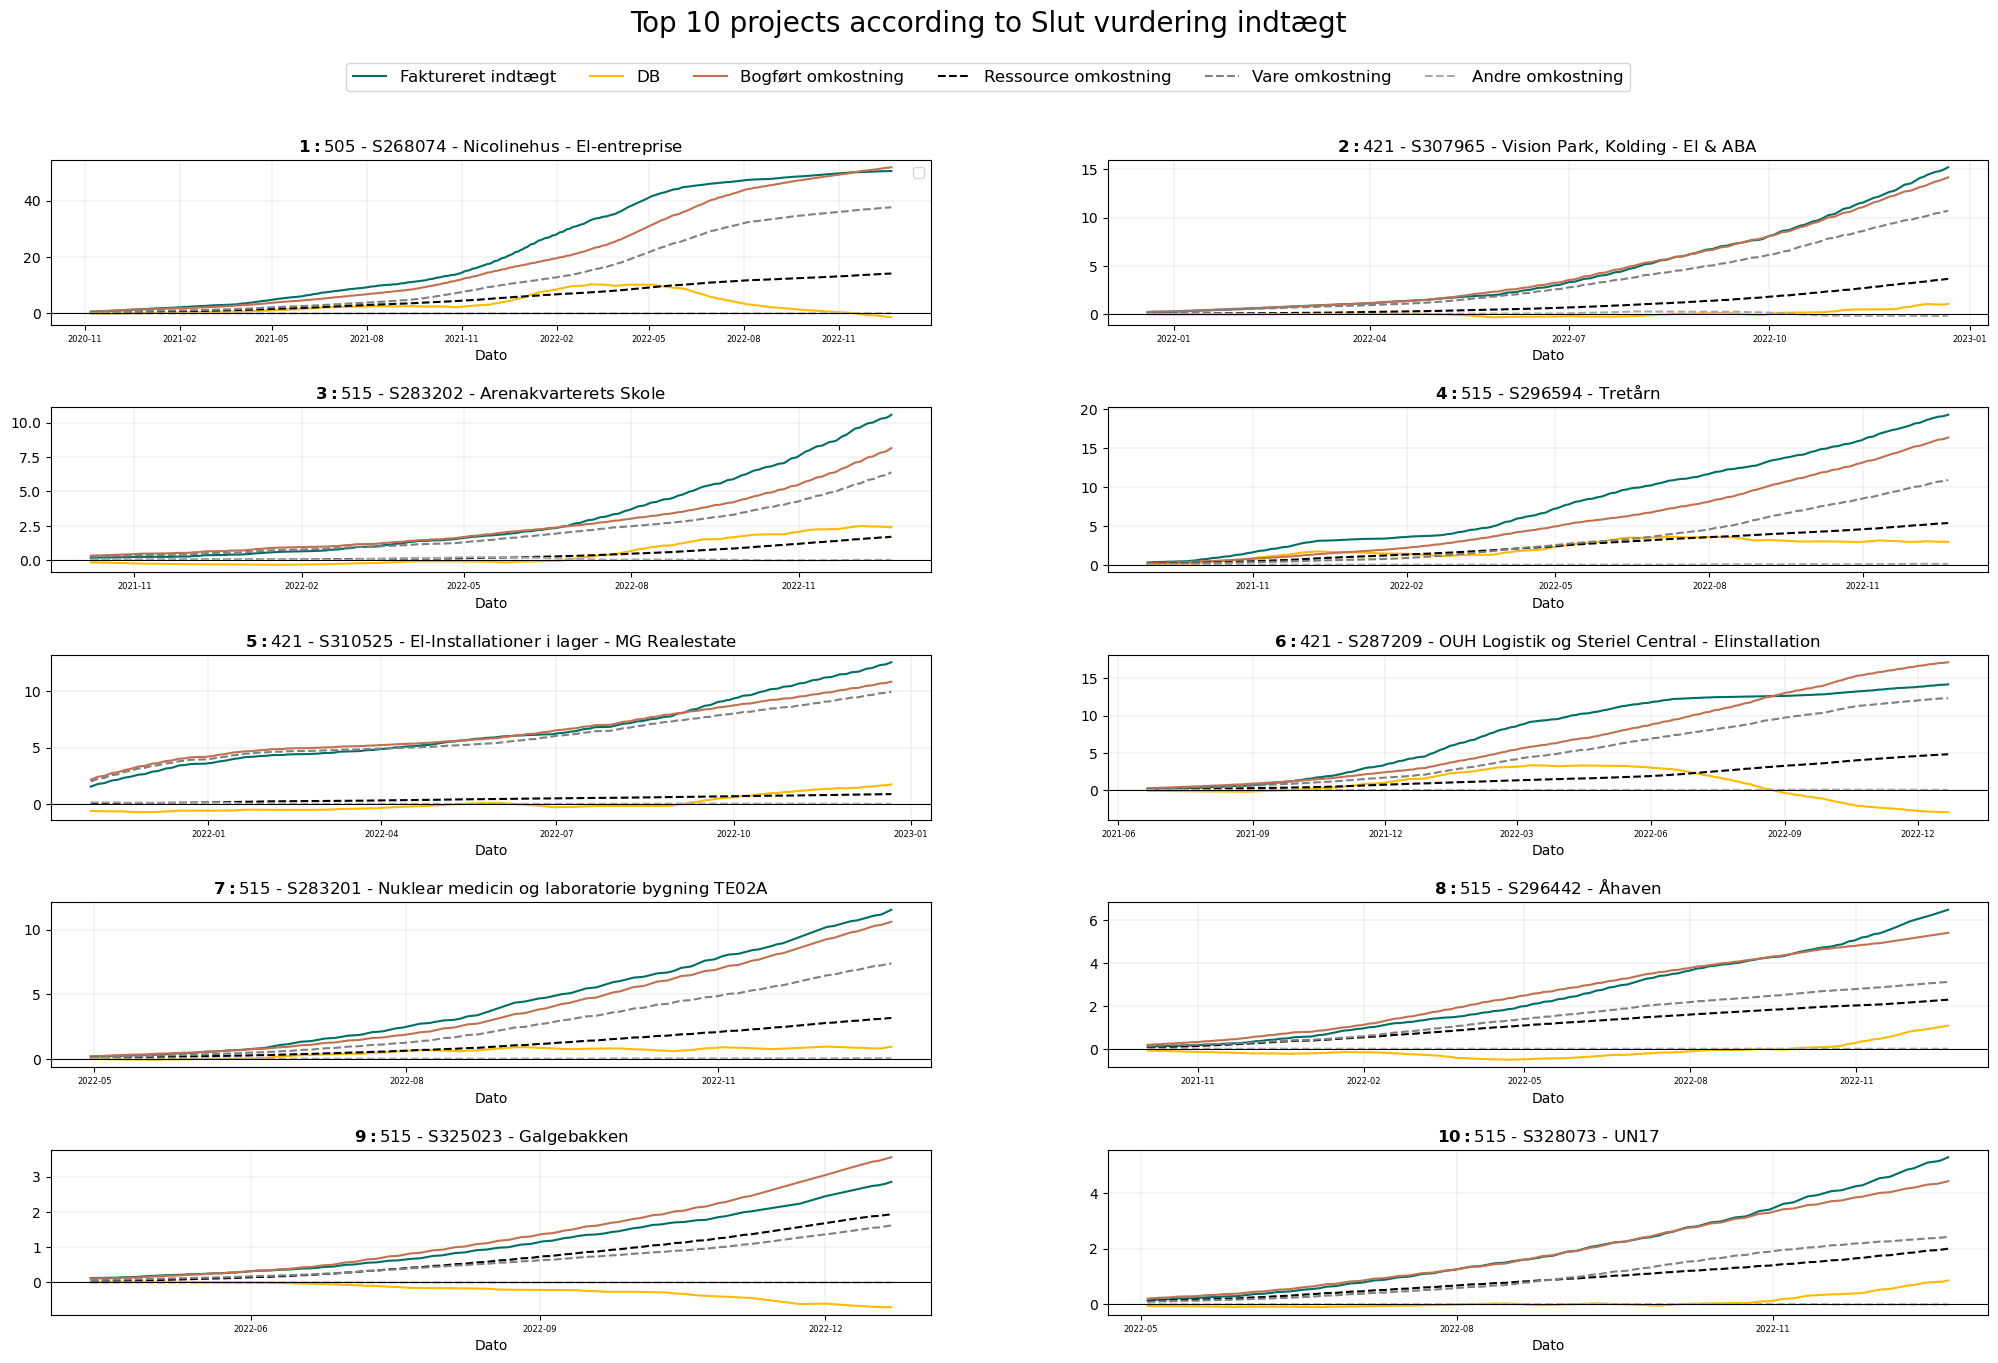

In [10]:
# Plot 10 project in one figure.
fig, ax = plt.subplots(5,2)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)
# size of the figure
fig.set_size_inches(25, 15)
# Title of the figure
fig.suptitle('Top 10 projects according to ' + param, fontsize=20)


# Project 1
ax[0,0].plot(dfJob1.index, dfJob1['Faktureret indtægt'], color='#006e64')
ax[0,0].plot(dfJob1.index, dfJob1['DB'], color='#ffbb00')
ax[0,0].plot(dfJob1.index, dfJob1['Bogført omkostning'],color='#c17150')
ax[0,0].plot(dfJob1.index, dfJob1['Ressource omkostning'],linestyle='--', color='black')
ax[0,0].plot(dfJob1.index, dfJob1['Vare omkostning'],linestyle='--', color='grey')
ax[0,0].plot(dfJob1.index, dfJob1['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[0,0].twinx()
# ax0.plot(dfJob1.index, dfJob1['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob1.index, dfJob1['Slut vurdering DG'], linestyle = '-.')
# Legend
ax[0,0].legend()
# Title
ax[0,0].set_title(r"$\bf{1: }$" + dfJob1Desc)
# X-axis
ax[0,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[0,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[0,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[0,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 2
ax[0,1].plot(dfJob2.index, dfJob2['Faktureret indtægt'], color='#006e64')
ax[0,1].plot(dfJob2.index, dfJob2['DB'], color='#ffbb00')
ax[0,1].plot(dfJob2.index, dfJob2['Bogført omkostning'],color='#c17150')
ax[0,1].plot(dfJob2.index, dfJob2['Ressource omkostning'], linestyle='--', color='black')
ax[0,1].plot(dfJob2.index, dfJob2['Vare omkostning'],linestyle='--', color='grey')
ax[0,1].plot(dfJob2.index, dfJob2['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[0,1].twinx()
# ax0.plot(dfJob2.index, dfJob2['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob2.index, dfJob2['Slut vurdering DG'], linestyle = '-.')
# Title
ax[0,1].set_title(r"$\bf{2: }$" + dfJob2Desc)
# X-axis
ax[0,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[0,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[0,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[0,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[0,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 3
ax[1,0].plot(dfJob3.index, dfJob3['Faktureret indtægt'], color='#006e64')
ax[1,0].plot(dfJob3.index, dfJob3['DB'], color='#ffbb00')
ax[1,0].plot(dfJob3.index, dfJob3['Bogført omkostning'],color='#c17150')
ax[1,0].plot(dfJob3.index, dfJob3['Ressource omkostning'],linestyle='--', color='black')
ax[1,0].plot(dfJob3.index, dfJob3['Vare omkostning'],linestyle='--', color='grey')
ax[1,0].plot(dfJob3.index, dfJob3['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[1,0].twinx()
# ax0.plot(dfJob3.index, dfJob3['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob3.index, dfJob3['Slut vurdering DG'], linestyle = '-.')
# Title
ax[1,0].set_title(r"$\bf{3: }$" + dfJob3Desc)
# X-axis
ax[1,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[1,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[1,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[1,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[1,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 4

ax[1,1].plot(dfJob4.index, dfJob4['Faktureret indtægt'], color='#006e64')
ax[1,1].plot(dfJob4.index, dfJob4['DB'], color='#ffbb00')
ax[1,1].plot(dfJob4.index, dfJob4['Bogført omkostning'],color='#c17150')
ax[1,1].plot(dfJob4.index, dfJob4['Ressource omkostning'],linestyle='--', color='black')
ax[1,1].plot(dfJob4.index, dfJob4['Vare omkostning'],linestyle='--', color='grey')
ax[1,1].plot(dfJob4.index, dfJob4['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[1,1].twinx()
# ax0.plot(dfJob4.index, dfJob4['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob4.index, dfJob4['Slut vurdering DG'], linestyle = '-.')
# Title
ax[1,1].set_title(r"$\bf{4: }$" + dfJob4Desc)
# X-axis
ax[1,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[1,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[1,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[1,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[1,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 5
ax[2,0].plot(dfJob5.index, dfJob5['Faktureret indtægt'], color='#006e64')
ax[2,0].plot(dfJob5.index, dfJob5['DB'], color='#ffbb00')
ax[2,0].plot(dfJob5.index, dfJob5['Bogført omkostning'],color='#c17150')
ax[2,0].plot(dfJob5.index, dfJob5['Ressource omkostning'],linestyle='--', color='black')
ax[2,0].plot(dfJob5.index, dfJob5['Vare omkostning'],linestyle='--', color='grey')
ax[2,0].plot(dfJob5.index, dfJob5['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[2,0].twinx()
# ax0.plot(dfJob4.index, dfJob4['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob4.index, dfJob4['Slut vurdering DG'], linestyle = '-.')
# Title
ax[2,0].set_title(r"$\bf{5: }$" + dfJob5Desc)
# X-axis
ax[2,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[2,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[2,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[2,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[2,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 6
ax[2,1].plot(dfJob6.index, dfJob6['Faktureret indtægt'], color='#006e64')
ax[2,1].plot(dfJob6.index, dfJob6['DB'], color='#ffbb00')
ax[2,1].plot(dfJob6.index, dfJob6['Bogført omkostning'],color='#c17150')
ax[2,1].plot(dfJob6.index, dfJob6['Ressource omkostning'],linestyle='--', color='black')
ax[2,1].plot(dfJob6.index, dfJob6['Vare omkostning'],linestyle='--', color='grey')
ax[2,1].plot(dfJob6.index, dfJob6['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[2,1].twinx()
# ax0.plot(dfJob6.index, dfJob6['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob6.index, dfJob6['Slut vurdering DG'], linestyle = '-.')
# Title
ax[2,1].set_title(r"$\bf{6: }$" + dfJob6Desc)
# X-axis
ax[2,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[2,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[2,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[2,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[2,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 7
ax[3,0].plot(dfJob7.index, dfJob7['Faktureret indtægt'], color='#006e64')
ax[3,0].plot(dfJob7.index, dfJob7['DB'], color='#ffbb00')
ax[3,0].plot(dfJob7.index, dfJob7['Bogført omkostning'],color='#c17150')
ax[3,0].plot(dfJob7.index, dfJob7['Ressource omkostning'],linestyle='--', color='black')
ax[3,0].plot(dfJob7.index, dfJob7['Vare omkostning'],linestyle='--', color='grey')
ax[3,0].plot(dfJob7.index, dfJob7['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[3,0].twinx()
# ax0.plot(dfJob7.index, dfJob7['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob7.index, dfJob7['Slut vurdering DG'], linestyle = '-.')
# Title
ax[3,0].set_title(r"$\bf{7: }$" + dfJob7Desc)
# X-axis
ax[3,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[3,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[3,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[3,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[3,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 8
ax[3,1].plot(dfJob8.index, dfJob8['Faktureret indtægt'], color='#006e64')
ax[3,1].plot(dfJob8.index, dfJob8['DB'], color='#ffbb00')
ax[3,1].plot(dfJob8.index, dfJob8['Bogført omkostning'],color='#c17150')
ax[3,1].plot(dfJob8.index, dfJob8['Ressource omkostning'],linestyle='--', color='black')  
ax[3,1].plot(dfJob8.index, dfJob8['Vare omkostning'],linestyle='--', color='grey')
ax[3,1].plot(dfJob8.index, dfJob8['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[3,1].twinx()
# ax0.plot(dfJob8.index, dfJob8['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob8.index, dfJob8['Slut vurdering DG'], linestyle = '-.')
# Title
ax[3,1].set_title(r"$\bf{8: }$" + dfJob8Desc)
# X-axis
ax[3,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[3,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[3,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[3,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[3,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 9
ax[4,0].plot(dfJob9.index, dfJob9['Faktureret indtægt'], color='#006e64')
ax[4,0].plot(dfJob9.index, dfJob9['DB'], color='#ffbb00')
ax[4,0].plot(dfJob9.index, dfJob9['Bogført omkostning'],color='#c17150')
ax[4,0].plot(dfJob9.index, dfJob9['Ressource omkostning'],linestyle='--', color='black')
ax[4,0].plot(dfJob9.index, dfJob9['Vare omkostning'],linestyle='--', color='grey')
ax[4,0].plot(dfJob9.index, dfJob9['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[4,0].twinx()
# ax0.plot(dfJob9.index, dfJob9['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob9.index, dfJob9['Slut vurdering DG'], linestyle = '-.')
# Title
ax[4,0].set_title(r"$\bf{9: }$" + dfJob9Desc)
# X-axis
ax[4,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[4,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[4,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[4,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[4,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 10
ax[4,1].plot(dfJob10.index, dfJob10['Faktureret indtægt'], color='#006e64')
ax[4,1].plot(dfJob10.index, dfJob10['DB'], color='#ffbb00')
ax[4,1].plot(dfJob10.index, dfJob10['Bogført omkostning'],color='#c17150')
ax[4,1].plot(dfJob10.index, dfJob10['Ressource omkostning'],linestyle='--', color='black')
ax[4,1].plot(dfJob10.index, dfJob10['Vare omkostning'],linestyle='--', color='grey')
ax[4,1].plot(dfJob10.index, dfJob10['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[4,1].twinx()
# ax0.plot(dfJob10.index, dfJob10['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob10.index, dfJob10['Slut vurdering DG'], linestyle = '-.')
# Title
ax[4,1].set_title(r"$\bf{10: }$" + dfJob10Desc)
# X-axis
ax[4,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[4,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[4,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[4,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[4,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)


# Legend below title
# Add label to legend
fig.legend(['Faktureret indtægt', 'DB', 'Bogført omkostning', 'Ressource omkostning', 'Vare omkostning', 'Andre omkostning'],loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=6, fontsize=12)

plt.show()

### PyCaret Machine Learning Library ###

In [14]:
from pycaret.regression import *
dfML = dfJob1
dfML

,Uge,Måned-år,År,Sagsbogføringsgruppe,Afd,Sagsnr.,Beskrivelse,Kundenavn,Slut vurdering indtægt,Slut vurdering omkostning,Slut vurdering DB,Faktureret indtægt,Bogført omkostning,Ressource omkostning,Vare omkostning,Andre omkostning,DG,DB,Slut vurdering DG
Dato,,,,,,,,,,,,,,,,,,,
2020-11-07,45.0,2020-11-01,2020,FASTPRIS,505,S268074,Nicolinehus - El-entreprise,NCC Danmark A/S,1596.936442,1637.934047,-40.997605,0.588398,0.637859,0.253368,0.384690,-0.000199,-0.084059,-0.049460,-0.025673
2020-11-09,46.0,2020-11-01,2020,FASTPRIS,505,S268074,Nicolinehus - El-entreprise,NCC Danmark A/S,1649.295014,1691.636802,-42.341788,0.609013,0.661446,0.261624,0.400021,-0.000199,-0.086096,-0.052434,-0.025673
2020-11-10,46.0,2020-11-01,2020,FASTPRIS,505,S268074,Nicolinehus - El-entreprise,NCC Danmark A/S,1701.653586,1745.339558,-43.685972,0.629628,0.685105,0.269963,0.415341,-0.000199,-0.088112,-0.055478,-0.025673
2020-11-11,46.0,2020-11-01,2020,FASTPRIS,505,S268074,Nicolinehus - El-entreprise,NCC Danmark A/S,1754.012158,1799.042314,-45.030156,0.650242,0.708796,0.278334,0.430661,-0.000199,-0.090050,-0.058554,-0.025673
2020-11-12,46.0,2020-11-01,2020,FASTPRIS,505,S268074,Nicolinehus - El-entreprise,NCC Danmark A/S,1806.370730,1852.745069,-46.374340,0.670857,0.732417,0.286695,0.445920,-0.000199,-0.091763,-0.061560,-0.025673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-16,50.0,2022-12-01,2022,FASTPRIS,505,S268074,Nicolinehus - El-entreprise,NCC Danmark A/S,33064.438136,33913.290180,-848.852044,50.494238,51.623833,14.071050,37.510005,0.042778,-0.022371,-1.129596,-0.025673
2022-12-19,51.0,2022-12-01,2022,FASTPRIS,505,S268074,Nicolinehus - El-entreprise,NCC Danmark A/S,33116.796708,33966.992936,-850.196228,50.504560,51.687821,14.092945,37.554232,0.040644,-0.023429,-1.183261,-0.025673
2022-12-20,51.0,2022-12-01,2022,FASTPRIS,505,S268074,Nicolinehus - El-entreprise,NCC Danmark A/S,33169.155280,34020.695692,-851.540412,50.514883,51.752219,14.114742,37.598968,0.038509,-0.024495,-1.237337,-0.025673


In [13]:
# Setup the model #
s = setup(dfML, target = 'DB', fold_shuffle=True)


IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:18:09
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
Uge,Numeric
Måned-år,Date
År,Categorical
Sagsbogføringsgruppe,Categorical
Afd,Categorical
Sagsnr.,Categorical
Beskrivelse,Categorical
Kundenavn,Categorical
Slut vurdering indtægt,Numeric
Slut vurdering omkostning,Numeric


: 

### Forecast the DB on project 1 using a deep neural network ###

In [ ]:
# # plot feature importance using built-in function
# import xgboost as xgb
# from sklearn.metrics import mean_squared_error

# dfRF = dfJob1
# # split data into X and y

# vY =  np.array(dfRF['DB']).reshape(-1,1)

# x1 = np.array(dfRF['Slut vurdering indtægt']).reshape(-1,1)
# x2 = np.array(dfRF['Slut vurdering omkostning']).reshape(-1,1)
# x3 = np.array(dfRF['Slut vurdering DB']).reshape(-1,1)
# x4 = np.array(dfRF['Slut vurdering DG']).reshape(-1,1)
# x5 = np.array(dfRF['Faktureret indtægt']).reshape(-1,1)
# x5_l1 = np.array(dfRF['Faktureret indtægt'].shift(-1).fillna(0)).reshape(-1,1)
# x6 = np.array(dfRF['DG']).reshape(-1,1)
# x6_l1 = np.array(dfRF['DG'].shift(-1).fillna(0)).reshape(-1,1)
# x7 = np.array(dfRF['Ressource omkostning']).reshape(-1,1)
# x7_l1 = np.array(dfRF['Ressource omkostning'].shift(-1).fillna(0)).reshape(-1,1)
# x8 = np.array(dfRF['Vare omkostning']).reshape(-1,1)
# x8_l1 = np.array(dfRF['Vare omkostning'].shift(-1).fillna(0)).reshape(-1,1)
# x9 = np.array(dfRF['Andre omkostning']).reshape(-1,1)
# x9_l1 = np.array(dfRF['Andre omkostning'].shift(-1).fillna(0)).reshape(-1,1)
# x10 = np.array(dfRF['Uge']).reshape(-1,1)

# mX = np.concatenate((x1,x2,x3,x4,x5,x5_l1,x6,x6_l1,x7,x7_l1,x8,x8_l1,x9,x9_l1,x10),axis=1)

# data_dmatrix = xgb.DMatrix(data=mX,label=vY)

# n = len(dfRF)
# # Split the data into training and test data
# mX_train, mX_test, vY_train, vY_test = train_test_split(mX, vY, test_size=0.2, random_state=42, shuffle=True)
# mX_train, mX_val, vY_train, vY_val = train_test_split(mX_train, vY_train, test_size=0.25, random_state=42, shuffle=True)

# # Forest parameters

# params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
#                 'max_depth': 8, 'alpha': 10}

# cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
#                     num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

# xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=42)

# predictions = xg_reg.predict(data_dmatrix, ntree_limit=xg_reg.best_ntree_limit, validate_features=True)

# predictions = pd.DataFrame(predictions, columns=['Predicted Values'])

# ### Plot the predictions ###
# fig, ax = plt.subplots()
# # size of the figure
# fig.set_size_inches(25, 15)
# # Title of the figure
# dfRFDesc = dfRF.iloc[0]['Afd'] +' - '+ dfRF.iloc[0]['Sagsnr.'] +' - '+ dfRF.iloc[0]['Beskrivelse']

# # Project 1
# ax.plot(dfRF.index, dfRF['Faktureret indtægt'], color='#006e64')
# ax.plot(dfRF.index, dfRF['DB'], color='#ffbb00')
# ax.plot(dfRF.index, predictions, color='#ffbb00', linestyle='--')
# ax.plot(dfRF.index, dfRF['Bogført omkostning'],color='#c17150')

# # Legend
# ax.legend()
# # Title
# ax.set_title(dfRFDesc)
# # X-axis
# ax.set_xlabel('Dato')
# # Change x-axis ticks to every 3 months
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# # X-axis label size small
# ax.tick_params(axis='x', labelsize=6)
# # Add gridlines grey
# ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# # Add line for y=0
# ax.axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# fig.legend(['Faktureret indtægt', 'DB', 'Forecast DB', 'Bogført omkostning'],loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=4, fontsize=12)

# plt.show()



### Predict using Long-Short Term Memory ###

In [15]:
# Function to reshape data for LSTM
def df_to_mX_vY(df, window_size):
    df = df.to_numpy()
    mX = []
    vY = []
    for i in range(len(df) - window_size - 1):
        a = df[i:(i + window_size)]
        mX.append(a)
        vY.append(df[i + window_size])
    return np.array(mX), np.array(vY)

In [16]:
window_size = 3
dfRF = dfJob1
mX, vY = df_to_mX_vY(dfRF['DB'], window_size)

In [17]:
mX_train, mX_test, vY_train, vY_test = train_test_split(mX, vY, test_size=0.2, random_state=42, shuffle=True)
mX_train, mX_val, vY_train, vY_val = train_test_split(mX_train, vY_train, test_size=0.25, random_state=42, shuffle=True)
mX_train.shape, mX_val.shape, mX_test.shape, vY_train.shape, vY_val.shape, vY_test.shape

((360, 3), (121, 3), (121, 3), (360,), (121,), (121,))

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [19]:
model1 = Sequential()
model1.add(InputLayer((window_size, 1)))
model1.add(LSTM(64))
model1.add(Dense(16,'relu'))
model1.add(Dense(1,'linear'))

model1.summary()

cp = ModelCheckpoint(filepath="model1/", save_best_only=True, verbose=0)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=['mse'])
model1.fit(mX_train, vY_train, epochs=10, batch_size=32, validation_data=(mX_val, vY_val), callbacks=[cp])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 17,953
Trainable params: 17,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 1/12 [=>............................] - ETA: 16s - loss: 32.1280 - mse: 32.1280

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12/12 [==============================] - 8s 558ms/step - loss: 28.6180 - mse: 28.6180 - val_loss: 25.2275 - val_mse: 25.2275
Epoch 2/10
 1/12 [=>............................] - ETA: 0s - loss: 30.0290 - mse: 30.0290

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12/12 [==============================] - 5s 496ms/step - loss: 27.3451 - mse: 27.3451 - val_loss: 24.0801 - val_mse: 24.0801
Epoch 3/10
 1/12 [=>............................] - ETA: 0s - loss: 21.1079 - mse: 21.1079

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12/12 [==============================] - 6s 523ms/step - loss: 26.0674 - mse: 26.0674 - val_loss: 22.9765 - val_mse: 22.9765
Epoch 4/10
 1/12 [=>............................] - ETA: 0s - loss: 19.3302 - mse: 19.3302

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12/12 [==============================] - 6s 510ms/step - loss: 24.8879 - mse: 24.8879 - val_loss: 21.9707 - val_mse: 21.9707
Epoch 5/10
 1/12 [=>............................] - ETA: 0s - loss: 35.6833 - mse: 35.6833

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12/12 [==============================] - 6s 516ms/step - loss: 23.8137 - mse: 23.8137 - val_loss: 21.0369 - val_mse: 21.0369
Epoch 6/10
 1/12 [=>............................] - ETA: 0s - loss: 24.9977 - mse: 24.9977

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12/12 [==============================] - 6s 509ms/step - loss: 22.8233 - mse: 22.8233 - val_loss: 20.1663 - val_mse: 20.1663
Epoch 7/10
 1/12 [=>............................] - ETA: 0s - loss: 22.5378 - mse: 22.5378

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12/12 [==============================] - 6s 525ms/step - loss: 21.8871 - mse: 21.8871 - val_loss: 19.3382 - val_mse: 19.3382
Epoch 8/10
 1/12 [=>............................] - ETA: 0s - loss: 16.4307 - mse: 16.4307

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12/12 [==============================] - 6s 514ms/step - loss: 21.0113 - mse: 21.0113 - val_loss: 18.6266 - val_mse: 18.6266
Epoch 9/10
 1/12 [=>............................] - ETA: 0s - loss: 20.6620 - mse: 20.6620

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12/12 [==============================] - 6s 514ms/step - loss: 20.2273 - mse: 20.2273 - val_loss: 17.8696 - val_mse: 17.8696
Epoch 10/10
 1/12 [=>............................] - ETA: 0s - loss: 15.3943 - mse: 15.3943

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


12/12 [==============================] - 6s 536ms/step - loss: 19.3226 - mse: 19.3226 - val_loss: 16.9942 - val_mse: 16.9942


12/12 [==============================] - 0s 3ms/step


(       Actuals  Predictions
 0     5.851324     1.198766
 1     4.991293     1.112514
 2     3.721945     0.871733
 3     9.913460     1.351368
 4     3.822111     0.888424
 5     5.945066     1.152806
 6     0.053609     0.093342
 7     0.413601     0.204633
 8     7.145914     1.248873
 9     1.426659     0.428491
 10    5.747120     1.188055
 11   -0.456051    -0.007585
 12    1.965775     0.577140
 13    8.746273     1.325087
 14    4.304969     1.024112
 15    0.293486     0.173246
 16    0.382608     0.196662
 17    2.294685     0.618503
 18    3.624218     0.854675
 19    0.536356     0.222133
 20    2.442276     0.695043
 21   10.164123     1.354125
 22    2.401303     0.657342
 23   10.145200     1.352769
 24    2.829470     0.724695
 25    8.252486     1.329930
 26    2.954731     0.761359
 27    9.939091     1.354596
 28   -0.981699    -0.037959
 29    4.594290     1.062724
 30    2.060170     0.599803
 31   10.167696     1.354133
 32   -0.730572    -0.025171
 33    6.84152

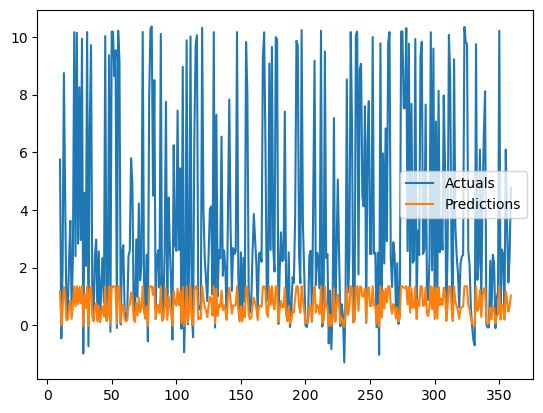

In [21]:
from sklearn.metrics import mean_squared_error

def plot_predictions1(model, mX, vY, start=0, end=len(vY)):
    predictions = model.predict(mX).flatten()
    df = pd.DataFrame({'Actuals': vY, 'Predictions': predictions})
    plt.plot(df['Actuals'][start:end])
    plt.plot(df['Predictions'][start:end])
    plt.legend(['Actuals', 'Predictions'])
    return df, mean_squared_error(df['Actuals'], df['Predictions'])


model1 = load_model('model1/')
plot_predictions1(model1, mX_train, vY_train, 10)

In [23]:
model2 = Sequential()
model2.add(InputLayer((window_size, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(16,'relu'))
model2.add(Dense(1,'linear'))

model2.summary()

cp = ModelCheckpoint(filepath="model2/", save_best_only=True, verbose=0)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=['mse'])
model2.fit(mX_train, vY_train, epochs=10, batch_size=32, validation_data=(mX_val, vY_val), callbacks=[cp])
model2 = load_model('model2/')

plot_predictions1(model2, mX_test, vY_test, 10)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2, 64)             192       
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 16)                2064      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,273
Trainable params: 2,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 1/12 [=>............................] - ETA: 5s - loss: 31.2188 - mse: 31.2188

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


12/12 [==============================] - 2s 107ms/step - loss: 28.8634 - mse: 28.8634 - val_loss: 23.1107 - val_mse: 23.1107
Epoch 2/10
 1/12 [=>............................] - ETA: 0s - loss: 32.0388 - mse: 32.0388

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


12/12 [==============================] - 1s 121ms/step - loss: 23.2794 - mse: 23.2794 - val_loss: 18.4999 - val_mse: 18.4999
Epoch 3/10
 1/12 [=>............................] - ETA: 0s - loss: 23.1647 - mse: 23.1647

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


12/12 [==============================] - 1s 99ms/step - loss: 18.6003 - mse: 18.6003 - val_loss: 14.6427 - val_mse: 14.6427
Epoch 4/10
 1/12 [=>............................] - ETA: 0s - loss: 20.0259 - mse: 20.0259

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


12/12 [==============================] - 1s 121ms/step - loss: 14.8273 - mse: 14.8273 - val_loss: 11.8442 - val_mse: 11.8442
Epoch 5/10
 1/12 [=>............................] - ETA: 0s - loss: 14.2593 - mse: 14.2593

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


12/12 [==============================] - 1s 104ms/step - loss: 12.0490 - mse: 12.0490 - val_loss: 9.6219 - val_mse: 9.6219
Epoch 6/10
 1/12 [=>............................] - ETA: 0s - loss: 16.2692 - mse: 16.2692